In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from math import pi 
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

In [29]:
print("="*70)
print("MODELO INTEGRADO: SEGMENTACIÓN RFM + PREDICCIÓN CHURN")
print("="*70)

# ==================== CARGA DE DATOS ====================
print("\n1. CARGA DE DATOS")
clientes = pd.read_excel('C:/Users/carri/Documents/GitHub/proyectos_python_ibm/Grupo 8 - proyecto Aurelion/Proyecto aurelion/resultados/cliente_limpio_data_aumentada.xlsx')
productos = pd.read_excel('C:/Users/carri/Documents/GitHub/proyectos_python_ibm/Grupo 8 - proyecto Aurelion/Proyecto aurelion/resultados/productos_limpio_data_aumentada.xlsx')
ventas = pd.read_excel('C:/Users/carri/Documents/GitHub/proyectos_python_ibm/Grupo 8 - proyecto Aurelion/Proyecto aurelion/resultados/ventas_limpio_data_aumentada.xlsx')
detalle = pd.read_excel('C:/Users/carri/Documents/GitHub/proyectos_python_ibm/Grupo 8 - proyecto Aurelion/Proyecto aurelion/resultados/detalle_ventas_limpio_data_aumentada.xlsx')

print(f"✓ Clientes: {len(clientes)}")
print(f"✓ Productos: {len(productos)}")
print(f"✓ Ventas: {len(ventas)}")
print(f"✓ Detalles: {len(detalle)}")

fecha_corte = ventas['fecha'].max()
print(f"✓ Fecha de corte: {fecha_corte.date()}")

MODELO INTEGRADO: SEGMENTACIÓN RFM + PREDICCIÓN CHURN

1. CARGA DE DATOS
✓ Clientes: 500
✓ Productos: 500
✓ Ventas: 1750
✓ Detalles: 4876
✓ Fecha de corte: 2025-12-07


In [39]:
# ==================== PARTE 1: SEGMENTACIÓN RFM ====================
print("\n" + "="*70)
print("PARTE 1: SEGMENTACIÓN RFM")
print("="*70)

# Calcular métricas RFM por cliente
print("\n2. CÁLCULO MÉTRICAS RFM")

# RECENCY: Días desde última compra
recency = ventas.groupby('id_cliente')['fecha'].max().reset_index()
recency['recency'] = (fecha_corte - recency['fecha']).dt.days
recency = recency[['id_cliente', 'recency']]

# FREQUENCY: Número de compras
frequency = ventas.groupby('id_cliente')['id_venta'].count().reset_index()
frequency.columns = ['id_cliente', 'frequency']

# MONETARY: Gasto total
monetary = detalle.merge(ventas[['id_venta', 'id_cliente']], on='id_venta')
monetary = monetary.groupby('id_cliente')['importe'].sum().reset_index()
monetary.columns = ['id_cliente', 'monetary']

# Combinar RFM
rfm = recency.merge(frequency, on='id_cliente').merge(monetary, on='id_cliente')

print(f"✓ Clientes con métricas RFM: {len(rfm)}")
print("\nEstadísticas RFM:")
print(rfm[['recency', 'frequency', 'monetary']].describe())

# Crear quintiles (1=peor, 5=mejor)
# Para Recency: menor es mejor, entonces invertimos
rfm['R'] = pd.qcut(rfm['recency'], q=5, labels=[5,4,3,2,1], duplicates='drop')
rfm['F'] = pd.qcut(rfm['frequency'], q=5, labels=[1,2,3,4,5], duplicates='drop')
rfm['M'] = pd.qcut(rfm['monetary'], q=5, labels=[1,2,3,4,5], duplicates='drop')

# Convertir a int
rfm['R'] = rfm['R'].astype(int)
rfm['F'] = rfm['F'].astype(int)
rfm['M'] = rfm['M'].astype(int)

# Crear score RFM
rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)
rfm['RFM_Sum'] = rfm['R'] + rfm['F'] + rfm['M']

print("\n3. SEGMENTACIÓN DE CLIENTES")

# Definir segmentos basados en RFM
def asignar_segmento(row):
    R, F, M = row['R'], row['F'], row['M']
    
    # Campeones: RFM altos
    if R >= 4 and F >= 4 and M >= 4:
        return 'Campeones'
    
    # Clientes Leales: Compran frecuentemente
    elif F >= 4:
        return 'Leales'
    
    # Clientes Potenciales: Gastaron mucho pero hace tiempo
    elif M >= 4 and R <= 3:
        return 'Potencial Reactivar'
    
    # En Riesgo: Eran buenos pero están perdiendo actividad
    elif F >= 3 and R <= 2:
        return 'En Riesgo'
    
    # Hibernando: Hace mucho que no compran
    elif R == 1:
        return 'Hibernando'
    
    # Nuevos: Recientes pero pocas compras
    elif R >= 4 and F <= 2:
        return 'Nuevos'
    
    # Necesitan Atención: Actividad moderada-baja
    else:
        return 'Necesitan Atención'

rfm['Segmento'] = rfm.apply(asignar_segmento, axis=1)

print("\nDistribución de Segmentos:")
print(rfm['Segmento'].value_counts())

# Guardar segmentación
segmentacion = rfm[['id_cliente', 'recency', 'frequency', 'monetary', 
                     'R', 'F', 'M', 'RFM_Score', 'RFM_Sum', 'Segmento']]
segmentacion.to_excel('C:/Users/carri/Documents/GitHub/proyectos_python_ibm/Grupo 8 - proyecto Aurelion/Proyecto aurelion/Modelo Machine Learning/segmentacion_rfm.xlsx', index=False)
print("\n✓ Segmentación guardada en: segmentacion_rfm.xlsx")


PARTE 1: SEGMENTACIÓN RFM

2. CÁLCULO MÉTRICAS RFM
✓ Clientes con métricas RFM: 485

Estadísticas RFM:
          recency   frequency       monetary
count  485.000000  485.000000     485.000000
mean    27.606186    3.608247  143170.381443
std     93.164054    1.914261   82522.794545
min    -70.000000    1.000000    1268.000000
25%    -41.000000    2.000000   77818.000000
50%      1.000000    3.000000  130566.000000
75%     65.000000    5.000000  193017.000000
max    494.000000   10.000000  436830.000000

3. SEGMENTACIÓN DE CLIENTES

Distribución de Segmentos:
Segmento
Necesitan Atención     135
Leales                  76
Nuevos                  76
Hibernando              74
Campeones               71
Potencial Reactivar     39
En Riesgo               14
Name: count, dtype: int64

✓ Segmentación guardada en: segmentacion_rfm.xlsx


In [ ]:
print("="*70)
print("MODELO CHURN + PRÓXIMA COMPRA")
print("="*70)

print(f"✓ Clientes: {len(clientes)}, Ventas: {len(ventas)}, Detalles: {len(detalle)}")

# Fecha de corte para entrenar (usar fecha que permita ver 70 días adelante)
fecha_max = ventas['fecha'].max()
fecha_corte = fecha_max - pd.Timedelta(days=70)  # 70 días antes del final
print(f"✓ Fecha corte: {fecha_corte.date()}, Fecha máx: {fecha_max.date()}")

# ==================== FEATURE ENGINEERING (SIN DATA LEAKAGE) ====================
print("\n2. FEATURE ENGINEERING (solo datos <= fecha_corte)")

# Filtrar datos de entrenamiento (solo hasta fecha_corte)
ventas_train = ventas[ventas['fecha'] <= fecha_corte].copy()
detalle_train = detalle[detalle['id_venta'].isin(ventas_train['id_venta'])].copy()

# Merge para tener importes
ventas_detalle = ventas_train.merge(
    detalle_train.groupby('id_venta')['importe'].sum().reset_index(),
    on='id_venta'
)

# Features por cliente
features_list = []

for id_cliente in clientes['id_cliente']:
    cliente_ventas = ventas_detalle[ventas_detalle['id_cliente'] == id_cliente]
    cliente_info = clientes[clientes['id_cliente'] == id_cliente].iloc[0]
    
    if len(cliente_ventas) == 0:
        continue
    
    # RECENCIA
    dias_ultima_compra = (fecha_corte - cliente_ventas['fecha'].max()).days
    dias_primera_compra = (fecha_corte - cliente_ventas['fecha'].min()).days
    antiguedad_cliente = (fecha_corte - cliente_info['fecha_alta']).days
    
    # FRECUENCIA
    num_compras = len(cliente_ventas)
    freq_compra = num_compras / max(dias_primera_compra, 1) * 30  # compras por mes
    
    # Días promedio entre compras
    if num_compras > 1:
        fechas_sorted = cliente_ventas['fecha'].sort_values()
        dias_entre_compras = fechas_sorted.diff().dt.days.mean()
    else:
        dias_entre_compras = dias_primera_compra
    
    # MONETARIO
    ticket_promedio = cliente_ventas['importe'].mean()
    valor_total = cliente_ventas['importe'].sum()
    ticket_ultima_compra = cliente_ventas[cliente_ventas['fecha'] == cliente_ventas['fecha'].max()]['importe'].iloc[0]
    
    # PRODUCTOS
    productos_cliente = detalle_train[detalle_train['id_venta'].isin(cliente_ventas['id_venta'])]
    num_productos_unicos = productos_cliente['id_producto'].nunique()
    productos_por_compra = productos_cliente.groupby('id_venta')['id_producto'].count().mean()
    
    # CATEGORÍAS
    productos_info = productos_cliente.merge(productos[['id_producto', 'categoria']], on='id_producto')
    num_categorias = productos_info['categoria'].nunique()
    
    # TENDENCIA (últimos 30, 60 días)
    ventas_30d = cliente_ventas[cliente_ventas['fecha'] >= (fecha_corte - pd.Timedelta(days=30))]
    ventas_60d = cliente_ventas[cliente_ventas['fecha'] >= (fecha_corte - pd.Timedelta(days=60))]
    
    compras_30d = len(ventas_30d)
    compras_60d = len(ventas_60d)
    gasto_30d = ventas_30d['importe'].sum() if len(ventas_30d) > 0 else 0
    gasto_60d = ventas_60d['importe'].sum() if len(ventas_60d) > 0 else 0
    
    # COMPORTAMIENTO
    medio_pago_mas_usado = cliente_ventas['medio_pago'].mode()[0] if len(cliente_ventas) > 0 else 'efectivo'
    
    features_list.append({
        'id_cliente': id_cliente,
        'dias_ultima_compra': dias_ultima_compra,
        'dias_primera_compra': dias_primera_compra,
        'antiguedad_cliente': antiguedad_cliente,
        'num_compras': num_compras,
        'freq_compra_mes': freq_compra,
        'dias_entre_compras': dias_entre_compras,
        'ticket_promedio': ticket_promedio,
        'valor_total': valor_total,
        'ticket_ultima_compra': ticket_ultima_compra,
        'num_productos_unicos': num_productos_unicos,
        'productos_por_compra': productos_por_compra,
        'num_categorias': num_categorias,
        'compras_30d': compras_30d,
        'compras_60d': compras_60d,
        'gasto_30d': gasto_30d,
        'gasto_60d': gasto_60d,
        'medio_pago': medio_pago_mas_usado,
        'ciudad': cliente_info['ciudad']
    })

features = pd.DataFrame(features_list)
print(f"✓ Features creadas para {len(features)} clientes")

# ==================== DEFINIR TARGET (CHURN) ====================
print("\n3. DEFINIR TARGET (70 DÍAS SIN COMPRA)")

# Ver qué clientes compraron después de fecha_corte
ventas_futuro = ventas[(ventas['fecha'] > fecha_corte) & (ventas['fecha'] <= fecha_max)]

# Para cada cliente, ver cuándo fue su próxima compra después de fecha_corte
proxima_compra = ventas_futuro.groupby('id_cliente')['fecha'].min().reset_index()
proxima_compra.columns = ['id_cliente', 'proxima_compra']

# Merge con features
features = features.merge(proxima_compra, on='id_cliente', how='left')

# Calcular días hasta próxima compra
features['dias_hasta_proxima'] = (features['proxima_compra'] - fecha_corte).dt.days

# Target: churned = 1 si NO compró en 70 días o no tiene próxima compra
features['churned'] = ((features['dias_hasta_proxima'].isna()) | 
                       (features['dias_hasta_proxima'] > 70)).astype(int)

print(f"✓ Clientes activos: {(features['churned']==0).sum()}")
print(f"✓ Clientes churned: {(features['churned']==1).sum()}")

# ==================== SEPARAR CLIENTES NUEVOS VS ANTIGUOS ====================
print("\n4. SEPARAR CLIENTES NUEVOS VS ANTIGUOS")

# Clientes nuevos: menos de 60 días de antigüedad y pocas compras
features['es_nuevo'] = ((features['antiguedad_cliente'] < 60) | 
                        (features['num_compras'] <= 2)).astype(int)

clientes_nuevos = features[features['es_nuevo'] == 1].copy()
clientes_antiguos = features[features['es_nuevo'] == 0].copy()

print(f"✓ Clientes nuevos: {len(clientes_nuevos)}")
print(f"✓ Clientes antiguos: {len(clientes_antiguos)}")

# ==================== PREPARAR DATOS ====================
print("\n5. PREPARAR DATOS")

# Variables categóricas a dummies
cat_cols = ['medio_pago', 'ciudad']
num_cols = [col for col in features.columns if col not in 
            ['id_cliente', 'churned', 'es_nuevo', 'medio_pago', 'ciudad', 
             'proxima_compra', 'dias_hasta_proxima']]

# ==================== MODELO 1: CHURN (CLIENTES ANTIGUOS) ====================
print("\n" + "="*70)
print("MODELO 1: PREDICCIÓN CHURN (CLIENTES ANTIGUOS)")
print("="*70)

if len(clientes_antiguos) > 50:  # Mínimo para entrenar
    # Preparar dataset
    X_churn = clientes_antiguos[num_cols + cat_cols].copy()
    X_churn = pd.get_dummies(X_churn, columns=cat_cols, drop_first=True)
    y_churn = clientes_antiguos['churned']
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_churn, y_churn, test_size=0.2, random_state=42, stratify=y_churn
    )
    
    # Escalar
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Entrenar XGBoost
    print("\nEntrenando XGBoost...")
    model_churn = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42,
        eval_metric='logloss'
    )
    model_churn.fit(X_train_scaled, y_train)
    
    # Predicciones
    y_pred = model_churn.predict(X_test_scaled)
    y_pred_proba = model_churn.predict_proba(X_test_scaled)[:, 1]
    
    # Evaluación
    print("\nRESULTADOS:")
    print(classification_report(y_test, y_pred, target_names=['Activo', 'Churn']))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.3f}")
    
    # Feature importance
    feature_imp = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model_churn.feature_importances_
    }).sort_values('importance', ascending=False).head(10)
    
    print("\nTop 10 Features Importantes:")
    print(feature_imp.to_string(index=False))
    
    # Predicciones para todos los clientes antiguos
    X_antiguos_full = clientes_antiguos[num_cols + cat_cols].copy()
    X_antiguos_full = pd.get_dummies(X_antiguos_full, columns=cat_cols, drop_first=True)
    X_antiguos_full = X_antiguos_full.reindex(columns=X_train.columns, fill_value=0)
    X_antiguos_scaled = scaler.transform(X_antiguos_full)
    
    clientes_antiguos['prob_churn'] = model_churn.predict_proba(X_antiguos_scaled)[:, 1]
    clientes_antiguos['pred_churn'] = model_churn.predict(X_antiguos_scaled)

else:
    print("⚠ No hay suficientes clientes antiguos para entrenar modelo churn")

# ==================== MODELO 2: PRÓXIMA COMPRA (CLIENTES NUEVOS) ====================
print("\n" + "="*70)
print("MODELO 2: PREDICCIÓN PRÓXIMA COMPRA (CLIENTES NUEVOS)")
print("="*70)

if len(clientes_nuevos) > 30:
    # Solo clientes que sí volvieron a comprar (para entrenar)
    clientes_nuevos_con_compra = clientes_nuevos[clientes_nuevos['dias_hasta_proxima'].notna()].copy()
    
    if len(clientes_nuevos_con_compra) > 20:
        print(f"Entrenando con {len(clientes_nuevos_con_compra)} clientes nuevos que volvieron a comprar")
        
        # Preparar dataset
        X_proxima = clientes_nuevos_con_compra[num_cols + cat_cols].copy()
        X_proxima = pd.get_dummies(X_proxima, columns=cat_cols, drop_first=True)
        y_proxima = clientes_nuevos_con_compra['dias_hasta_proxima']
        
        # Split
        X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
            X_proxima, y_proxima, test_size=0.2, random_state=42
        )
        
        # Escalar
        scaler_proxima = StandardScaler()
        X_train_p_scaled = scaler_proxima.fit_transform(X_train_p)
        X_test_p_scaled = scaler_proxima.transform(X_test_p)
        
        # Entrenar Random Forest Regressor
        print("\nEntrenando Random Forest Regressor...")
        model_proxima = RandomForestRegressor(
            n_estimators=100,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        )
        model_proxima.fit(X_train_p_scaled, y_train_p)
        
        # Predicciones
        y_pred_p = model_proxima.predict(X_test_p_scaled)
        
        # Evaluación
        print("\nRESULTADOS:")
        print(f"MAE (días): {mean_absolute_error(y_test_p, y_pred_p):.1f}")
        print(f"R² Score: {r2_score(y_test_p, y_pred_p):.3f}")
        
        # Predicciones para todos los clientes nuevos
        X_nuevos_full = clientes_nuevos[num_cols + cat_cols].copy()
        X_nuevos_full = pd.get_dummies(X_nuevos_full, columns=cat_cols, drop_first=True)
        X_nuevos_full = X_nuevos_full.reindex(columns=X_train_p.columns, fill_value=0)
        X_nuevos_scaled = scaler_proxima.transform(X_nuevos_full)
        
        clientes_nuevos['dias_pred_proxima_compra'] = model_proxima.predict(X_nuevos_scaled)
        clientes_nuevos['riesgo_churn'] = (clientes_nuevos['dias_pred_proxima_compra'] > 70).astype(int)
    else:
        print("⚠ No hay suficientes clientes nuevos con compras futuras para entrenar")
else:
    print("⚠ No hay suficientes clientes nuevos para entrenar modelo")

# ==================== RESULTADOS FINALES ====================
print("\n" + "="*70)
print("RESULTADOS FINALES")
print("="*70)

# Combinar resultados
resultados_antiguos = clientes_antiguos[['id_cliente', 'prob_churn', 'pred_churn', 
                                         'churned', 'num_compras', 'valor_total']].copy()
resultados_antiguos['tipo'] = 'antiguo'
resultados_antiguos['dias_pred_proxima'] = np.nan

resultados_nuevos = clientes_nuevos[['id_cliente', 'churned', 'num_compras', 'valor_total']].copy()
resultados_nuevos['tipo'] = 'nuevo'
resultados_nuevos['prob_churn'] = np.nan
resultados_nuevos['pred_churn'] = np.nan
if 'dias_pred_proxima_compra' in clientes_nuevos.columns:
    resultados_nuevos['dias_pred_proxima'] = clientes_nuevos['dias_pred_proxima_compra']
else:
    resultados_nuevos['dias_pred_proxima'] = np.nan

# Combinar
resultados_final = pd.concat([resultados_antiguos, resultados_nuevos], ignore_index=True)

# Agregar info de clientes
resultados_final = resultados_final.merge(
    clientes[['id_cliente', 'nombre_cliente', 'email', 'ciudad']], 
    on='id_cliente'
)

print(f"\n✓ Total clientes evaluados: {len(resultados_final)}")
print(f"  - Clientes antiguos: {len(resultados_antiguos)}")
print(f"  - Clientes nuevos: {len(resultados_nuevos)}")

# Guardar resultados
resultados_final.to_excel('C:/Users/carri/Documents/GitHub/proyectos_python_ibm/Grupo 8 - proyecto Aurelion/Proyecto aurelion/Modelo Machine Learning/churn_resultados.xlsx', index=False)
print("\n✓ Predicciones guardadas en: predicciones_churn.xlsx")

print("\n" + "="*70)
print("ANÁLISIS COMPLETADO")
print("="*70)

MODELO CHURN + PRÓXIMA COMPRA
✓ Clientes: 500, Ventas: 1750, Detalles: 4876
✓ Fecha corte: 2025-09-28, Fecha máx: 2025-12-07

2. FEATURE ENGINEERING (solo datos <= fecha_corte)
✓ Features creadas para 474 clientes

3. DEFINIR TARGET (70 DÍAS SIN COMPRA)
✓ Clientes activos: 223
✓ Clientes churned: 251

4. SEPARAR CLIENTES NUEVOS VS ANTIGUOS
✓ Clientes nuevos: 252
✓ Clientes antiguos: 222

5. PREPARAR DATOS

MODELO 1: PREDICCIÓN CHURN (CLIENTES ANTIGUOS)

Entrenando XGBoost...

RESULTADOS:
              precision    recall  f1-score   support

      Activo       0.53      0.45      0.49        20
       Churn       0.61      0.68      0.64        25

    accuracy                           0.58        45
   macro avg       0.57      0.57      0.56        45
weighted avg       0.57      0.58      0.57        45

ROC-AUC Score: 0.598

Top 10 Features Importantes:
             feature  importance
       medio_pago_qr    0.072504
           gasto_30d    0.072220
productos_por_compra    0.0611

In [40]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("\nMatriz de Confusión:")
print(cm)
print("\n[Formato: Filas=Real, Columnas=Predicho]")
print(f"  Verdaderos Negativos (Activo→Activo): {cm[0,0]}")
print(f"  Falsos Positivos (Activo→Churn): {cm[0,1]}")
print(f"  Falsos Negativos (Churn→Activo): {cm[1,0]}")
print(f"  Verdaderos Positivos (Churn→Churn): {cm[1,1]}")


Matriz de Confusión:
[[ 9 11]
 [ 8 17]]

[Formato: Filas=Real, Columnas=Predicho]
  Verdaderos Negativos (Activo→Activo): 9
  Falsos Positivos (Activo→Churn): 11
  Falsos Negativos (Churn→Activo): 8
  Verdaderos Positivos (Churn→Churn): 17


📊 Cargando datos de segmentación RFM...
✓ Datos cargados: 485 clientes
✓ Segmentos: 7

📈 Calculando promedios por segmento...

Promedios RFM por Segmento:
                        R     F     M
Segmento                             
Campeones            4.52  4.65  4.69
En Riesgo            1.43  3.00  2.43
Hibernando           1.00  1.19  1.51
Leales               2.64  4.46  4.13
Necesitan Atención   3.01  1.84  2.36
Nuevos               4.53  1.47  2.33
Potencial Reactivar  2.31  2.38  4.26

✓ Gráfico individual guardado: radar_chart_rfm_individual.png

📊 Creando gráfico comparativo...
✓ Gráfico comparativo guardado: radar_chart_rfm_comparativo.png

ANÁLISIS DE PUNTOS FUERTES POR SEGMENTO

🎯 CAMPEONES
   R (Recency): 4.5/5 🟢
   F (Frequency): 4.7/5 🟢
   M (Monetary): 4.7/5 🟢
   💪 Punto fuerte: Gastan mucho dinero
   ⚠️  Punto débil: Hace tiempo que no compran

🎯 EN RIESGO
   R (Recency): 1.4/5 🔴
   F (Frequency): 3.0/5 🟡
   M (Monetary): 2.4/5 🔴
   💪 Punto fuerte: Compran frecuentemen

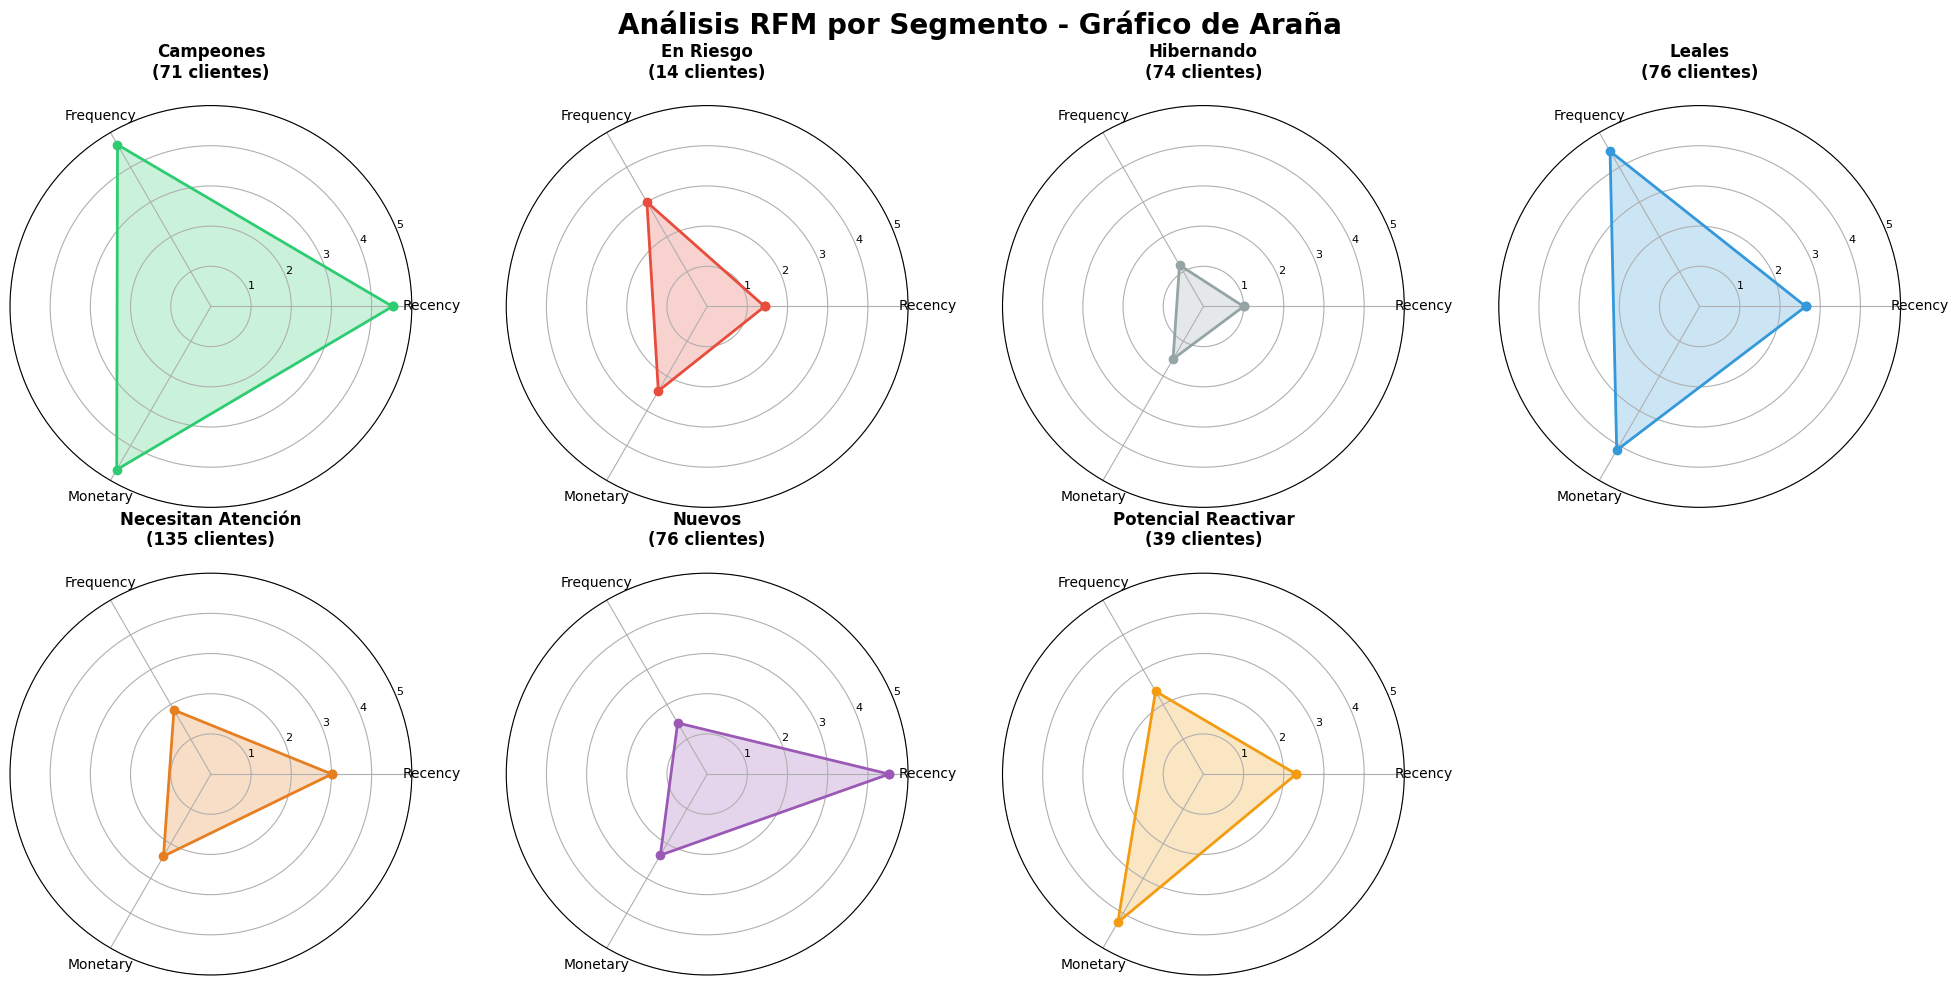

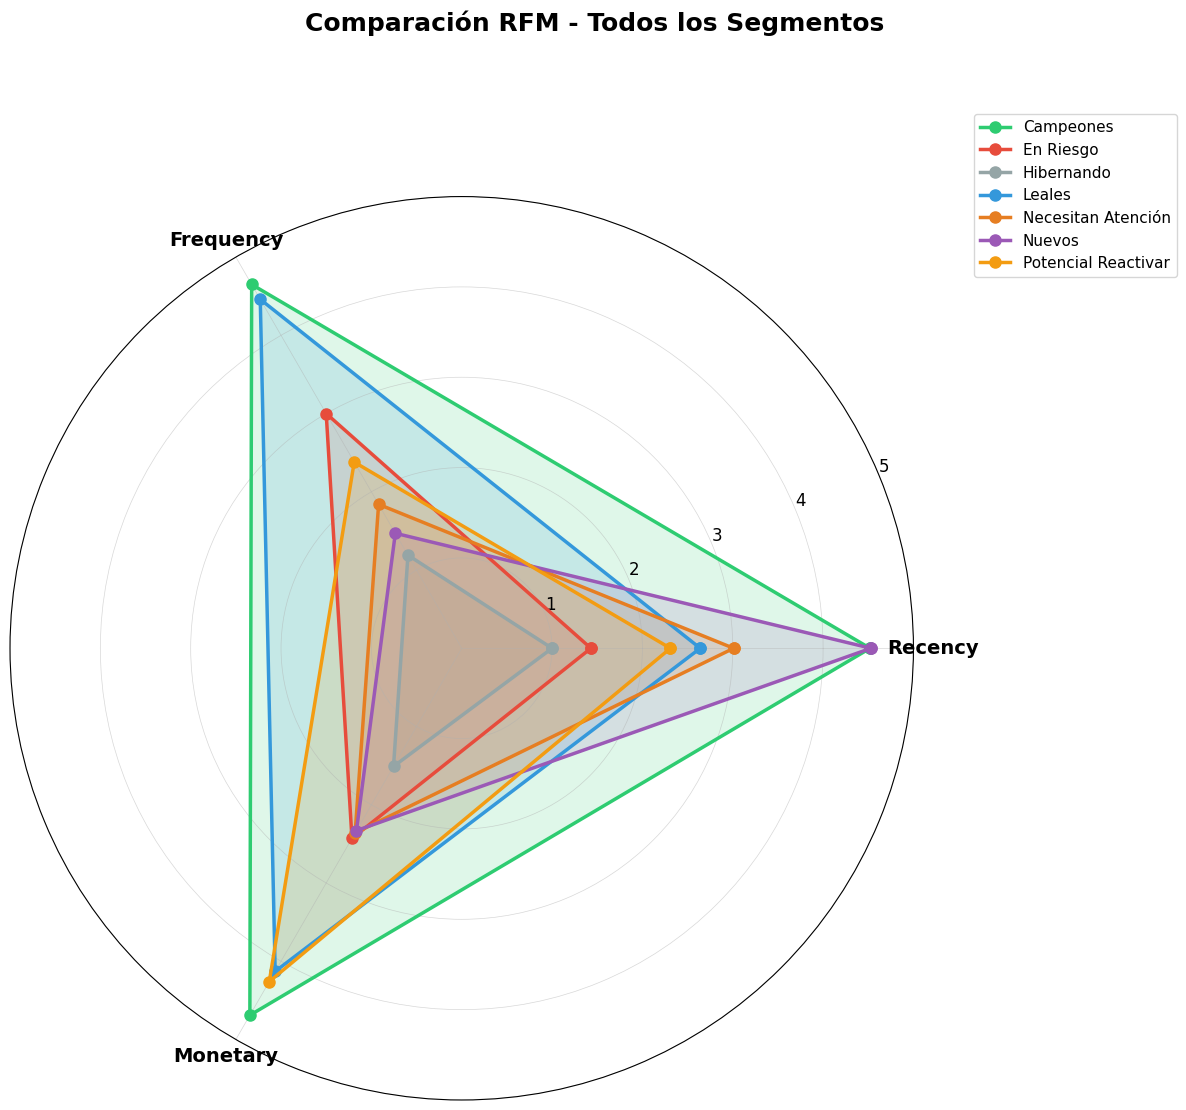

In [21]:
print("📊 Cargando datos de segmentación RFM...")
rfm = pd.read_excel('C:/Users/carri/Documents/GitHub/proyectos_python_ibm/Grupo 8 - proyecto Aurelion/Proyecto aurelion/Modelo Machine Learning/segmentacion_rfm.xlsx')

print(f"✓ Datos cargados: {len(rfm)} clientes")
print(f"✓ Segmentos: {rfm['Segmento'].nunique()}")

# Calcular promedio de R, F, M por segmento
print("\n📈 Calculando promedios por segmento...")
segmento_stats = rfm.groupby('Segmento')[['R', 'F', 'M']].mean().round(2)

print("\nPromedios RFM por Segmento:")
print(segmento_stats)

# Preparar datos para radar chart
categorias = ['Recency', 'Frequency', 'Monetary']
num_vars = len(categorias)

# Ángulos para cada eje
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]  # Cerrar el círculo

# Configurar figura
fig, axes = plt.subplots(2, 4, figsize=(20, 10), subplot_kw=dict(projection='polar'))
fig.suptitle('Análisis RFM por Segmento - Gráfico de Araña', fontsize=20, fontweight='bold')

axes = axes.flatten()

# Colores para cada segmento
colores = {
    'Campeones': '#2ecc71',
    'Leales': '#3498db',
    'Nuevos': '#9b59b6',
    'Necesitan Atención': '#e67e22',
    'Potencial Reactivar': '#f39c12',
    'En Riesgo': '#e74c3c',
    'Hibernando': '#95a5a6'
}

# Crear un gráfico para cada segmento
for idx, (segmento, row) in enumerate(segmento_stats.iterrows()):
    ax = axes[idx]
    
    # Valores del segmento
    valores = row.values.tolist()
    valores += valores[:1]  # Cerrar el polígono
    
    # Dibujar
    ax.plot(angles, valores, 'o-', linewidth=2, color=colores[segmento], label=segmento)
    ax.fill(angles, valores, alpha=0.25, color=colores[segmento])
    
    # Configurar ejes
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categorias, size=10)
    ax.set_ylim(0, 5)
    ax.set_yticks([1, 2, 3, 4, 5])
    ax.set_yticklabels(['1', '2', '3', '4', '5'], size=8)
    ax.grid(True)
    
    # Título con cantidad de clientes
    cantidad = len(rfm[rfm['Segmento'] == segmento])
    ax.set_title(f'{segmento}\n({cantidad} clientes)', 
                 size=12, fontweight='bold', pad=20)

# Ocultar el último subplot (si hay menos de 8 segmentos)
if len(segmento_stats) < 8:
    axes[-1].axis('off')

plt.tight_layout()
#plt.savefig('/mnt/user-data/outputs/radar_chart_rfm_individual.png', dpi=300, bbox_inches='tight')
print("\n✓ Gráfico individual guardado: radar_chart_rfm_individual.png")

# ==================== GRÁFICO COMPARATIVO (TODOS EN UNO) ====================
print("\n📊 Creando gráfico comparativo...")

fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection='polar'))
fig.suptitle('Comparación RFM - Todos los Segmentos', fontsize=18, fontweight='bold')

# Dibujar todos los segmentos en un solo gráfico
for segmento, row in segmento_stats.iterrows():
    valores = row.values.tolist()
    valores += valores[:1]
    
    ax.plot(angles, valores, 'o-', linewidth=2.5, 
            color=colores[segmento], label=segmento, markersize=8)
    ax.fill(angles, valores, alpha=0.15, color=colores[segmento])

# Configurar
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categorias, size=14, fontweight='bold')
ax.set_ylim(0, 5)
ax.set_yticks([1, 2, 3, 4, 5])
ax.set_yticklabels(['1', '2', '3', '4', '5'], size=12)
ax.grid(True, linewidth=0.5, alpha=0.5)

# Leyenda
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)

plt.tight_layout()
#plt.savefig('/mnt/user-data/outputs/radar_chart_rfm_comparativo.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico comparativo guardado: radar_chart_rfm_comparativo.png")

# ==================== ANÁLISIS DE PUNTOS FUERTES ====================
print("\n" + "="*70)
print("ANÁLISIS DE PUNTOS FUERTES POR SEGMENTO")
print("="*70)

for segmento, row in segmento_stats.iterrows():
    print(f"\n🎯 {segmento.upper()}")
    print(f"   R (Recency): {row['R']:.1f}/5 {'🟢' if row['R'] >= 4 else '🟡' if row['R'] >= 3 else '🔴'}")
    print(f"   F (Frequency): {row['F']:.1f}/5 {'🟢' if row['F'] >= 4 else '🟡' if row['F'] >= 3 else '🔴'}")
    print(f"   M (Monetary): {row['M']:.1f}/5 {'🟢' if row['M'] >= 4 else '🟡' if row['M'] >= 3 else '🔴'}")
    
    # Identificar punto más fuerte
    max_metric = row.idxmax()
    max_value = row.max()
    
    fortalezas = {
        'R': 'Compraron recientemente',
        'F': 'Compran frecuentemente',
        'M': 'Gastan mucho dinero'
    }
    
    print(f"   💪 Punto fuerte: {fortalezas[max_metric]}")
    
    # Identificar punto débil
    min_metric = row.idxmin()
    debilidades = {
        'R': 'Hace tiempo que no compran',
        'F': 'Compran poco frecuente',
        'M': 'Gastan poco'
    }
    print(f"   ⚠️  Punto débil: {debilidades[min_metric]}")

print("\n" + "="*70)
print("✅ PROCESO COMPLETADO")
print("="*70)
print("\nArchivos generados:")
print("1. radar_chart_rfm_individual.png - Gráficos individuales por segmento")
print("2. radar_chart_rfm_comparativo.png - Comparación de todos los segmentos")